# Imports and setup

In [1]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob
import rasterio
from rasterio import plot
from rasterio.plot import show
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as T
import matplotlib
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
import gc
import torchsummary
from datetime import datetime
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score


In [2]:
#torch seed and device info
torch.random.manual_seed(0)
!nvidia-smi

Thu Jul  3 23:39:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5500               Off |   00000000:01:00.0 Off |                  Off |
| 30%   28C    P8             23W /  230W |      11MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA RTX A5500 (UUID: GPU-8dd8bd39-a66b-8aa3-ce58-81c5e214a054)
GPU 1: NVIDIA RTX A5500 (UUID: GPU-0d143765-9b0e-0a6a-0f03-2a9a43a39889)
GPU 2: NVIDIA RTX A5500 (UUID: GPU-cd01c66c-b823-0ed5-f79c-20e623459232)


In [4]:
# Paths and data split
#images_dir = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/Input5bands"
images_dir = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/train4bands"
#masks_dir = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/Masks"
masks_dir = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/trainMasks"
#weights_path = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/weights"
weights_path = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/weightsTrainDS"
predictions_path = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/predictions"
valImgs = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/Input4bands"
valMasks = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/Masks"

In [5]:
# Customized DS for TIFF images (4 bands) y binary masks
class FourBandSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, files_list=None):
        if files_list is not None:
            self.image_files = files_list[0]
            self.mask_files = files_list[1]
        else:
            self.image_files = sorted(glob.glob(images_dir + "/*.tif"))
            self.mask_files = sorted(glob.glob(masks_dir + "/*.png"))
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        # 4 bands image
        with rasterio.open(self.image_files[idx]) as src:
            img = src.read()  # (bands, H, W)
            img = np.transpose(img, (1, 2, 0)).astype(np.float32)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            img = np.transpose(img, (2, 0, 1))  # (4, H, W)
        # Mask
        mask = Image.open(self.mask_files[idx]).convert('L')
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)  # (1, H, W)
        return torch.from_numpy(img), torch.from_numpy(mask)

In [6]:
image_files = sorted(glob.glob(images_dir + "/*.tif"))
mask_files = sorted(glob.glob(masks_dir + "/*.png"))
train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    image_files, mask_files, test_size=0.3, random_state=42
)

train_dataset = FourBandSegmentationDataset(images_dir, masks_dir, files_list=(train_imgs, train_masks))
test_dataset = FourBandSegmentationDataset(images_dir, masks_dir, files_list=(test_imgs, test_masks))


batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [7]:
val_files = sorted(glob.glob(valImgs + "/*.tif"))
val_masks_files = sorted(glob.glob(valMasks + "/*.png"))

val_imgs_tr, val_imgs_ts, val_masks_tr, val_masks_ts = train_test_split(
    val_files, val_masks_files, test_size=0.2, random_state=42
)

val_dataset = FourBandSegmentationDataset(valImgs, valMasks,files_list=(val_imgs_ts ,val_masks_ts))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [116]:
len(test_dataset), len(val_dataset)

(1307, 111)

# Define model

In [8]:
inputBands = 4
outputBands=1

In [18]:
# Unet and Def
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels,dropout=0.0):
        super().__init__()
        if dropout > 0.0:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout)
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
    def forward(self, x):
        return self.double_conv(x)

In [75]:
class UNet(nn.Module):
    def __init__(self, in_channels=inputBands, out_channels=outputBands):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024,dropout=0.05)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512,dropout=0.1)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256,dropout=0.1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128,dropout=0.1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64,dropout=0.1)
        self.conv_last = nn.Conv2d(64, out_channels, 1)
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        #return torch.sigmoid(self.conv_last(dec1))
        return self.conv_last(dec1) # No sigmoid here, we will apply it in the loss function

In [76]:
#list gpus available and its uuids
dc = torch.cuda.device_count()
print("Device count: " +  str(dc))
for i in range(dc):
    print("Device " + str(i) + ": " + str(torch.cuda.get_device_properties(i).uuid))

Device count: 3
Device 0: 8dd8bd39-a66b-8aa3-ce58-81c5e214a054
Device 1: 0d143765-9b0e-0a6a-0f03-2a9a43a39889
Device 2: cd01c66c-b823-0ed5-f79c-20e623459232


In [77]:
print(torch.cuda.is_available())
device = torch.device(2 if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

True
Device: cuda:2


In [14]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(1,2,3))
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth))
    return loss.mean()

In [15]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)

        # Dice
        smooth = 1e-6
        inputs = torch.sigmoid(inputs)
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)

        return 0.5 * bce_loss + 0.5 * dice_loss

In [78]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky

# Define hyperparameters, optimizations

In [79]:
model = UNet(in_channels=inputBands, out_channels=outputBands).to(device)
#criterion = BCEDiceLoss()
criterion = TverskyLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 30

In [80]:
model

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(

In [22]:
#print model summary
device = torch.device("cpu")
torchsummary.summary(model.to("cpu"), input_size=(inputBands, 512, 512), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           2,368
    InstanceNorm2d-2         [-1, 64, 512, 512]               0
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
    InstanceNorm2d-5         [-1, 64, 512, 512]               0
              ReLU-6         [-1, 64, 512, 512]               0
        DoubleConv-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,856
   InstanceNorm2d-10        [-1, 128, 256, 256]               0
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,584
   InstanceNorm2d-13        [-1, 128, 256, 256]               0
             ReLU-14        [-1, 128, 2

In [23]:
print(torch.cuda.is_available())
device = torch.device(2 if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

True
Device: cuda:2


In [22]:
def lrFinder(model, optimizer_class, criterion, dataloader, device, 
                     start_lr=1e-7, end_lr=1, num_iter=100):
    model.train()
    lrs = []
    losses = []

    lr_mult = (end_lr / start_lr) ** (1 / num_iter)
    lr = start_lr

    optimizer = optimizer_class(model.parameters(), lr=lr)
    iter_count = 0

    for inputs, targets in dataloader:
        if iter_count > num_iter:
            break

        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        lrs.append(lr)
        losses.append(loss.item())

        lr *= lr_mult
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        iter_count += 1

    return lrs, losses

Device: cuda:2


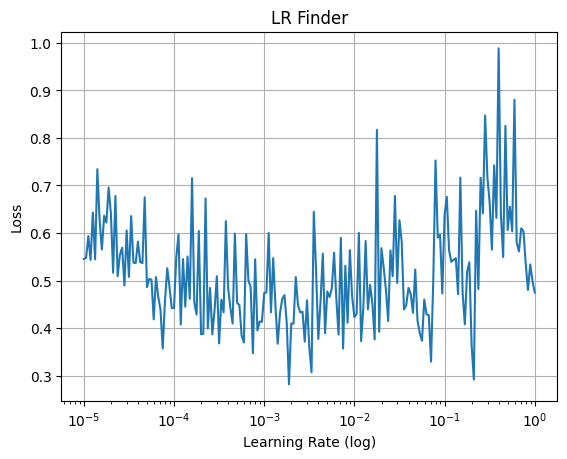

In [27]:
print(f"Device: {device}")
lrs, losses = lrFinder(model, torch.optim.AdamW, BCEDiceLoss(), train_loader, device,start_lr=1e-5,num_iter=200)

plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate (log)")
plt.ylabel("Loss")
plt.title("LR Finder")
plt.grid()
plt.show()

# Train the model

In [25]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
        else:
            reset_weights(layer)  # aplica recursivamente

In [81]:
reset_weights(model)

In [82]:
model

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(

In [28]:
def get_accuracy(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total

def get_jaccard(preds, targets, threshold=0.5, eps=1e-7):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + eps) / (union + eps)

def train_model(model, loss_function, optimizer, epochs, train_loader, test_loader, device,patience=5, save_path=None):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        #train_acc = 0.0
        train_jaccard = 0.0
        n_train = 0

        for imgs, masks in train_loader:
            imgs = imgs.to(device).float()
            masks = masks.to(device).float()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_function(outputs, masks)
            loss.backward()
            optimizer.step()
            batch_size = imgs.size(0)
            train_loss += loss.item() * batch_size
            #train_acc += get_accuracy(outputs, masks) * batch_size
            train_jaccard += get_jaccard(outputs, masks) * batch_size
            n_train += batch_size

        train_loss /= n_train
        #train_acc /= n_train
        train_jaccard /= n_train
        train_losses.append(train_loss)
        #train_accuracies.append(train_acc.cpu().item())
        train_accuracies.append(train_jaccard.cpu().item())

        model.eval()
        test_loss = 0.0
        #test_acc = 0.0
        test_jaccard = 0.0
        n_test = 0
        with torch.no_grad():
            for imgs, masks in test_loader:
                imgs = imgs.to(device).float()
                masks = masks.to(device).float()
                outputs = model(imgs)
                loss = loss_function(outputs, masks)
                batch_size = imgs.size(0)
                test_loss += loss.item() * batch_size
                #test_acc += get_accuracy(outputs, masks) * batch_size
                test_jaccard += get_jaccard(outputs, masks) * batch_size
                n_test += batch_size

        test_loss /= n_test
        #test_acc /= n_test
        test_jaccard /= n_test
        test_losses.append(test_loss)
        #test_accuracies.append(test_acc.cpu().item())
        test_accuracies.append(test_jaccard.cpu().item())

        #print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {test_loss:.4f} - val_acc: {test_acc:.4f}")
        print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - acc: {train_jaccard:.4f} - val_loss: {test_loss:.4f} - val_acc: {test_jaccard:.4f}")

        if save_path is not None:
            # Early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    return train_losses, test_losses, train_accuracies, test_accuracies

In [83]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
bestModel = os.path.join(weights_path, f"weights_{timestamp}.pth")
os.makedirs(os.path.dirname(bestModel), exist_ok=True)

In [84]:
bestModel

'/home/lcervantes/Dataset/Datasets/AI4boundariesDS/weightsTrainDS/weights_20250704_011921.pth'

In [85]:
print(f"Device: {device}")

Device: cuda:2


In [86]:
# Entrenamiento
#criterion = BCEDiceLoss()
criterion = TverskyLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 30

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, criterion, optimizer, epochs, test_loader, val_loader, device,patience = 5,save_path=bestModel
)

Epoch 1/30 - loss: 0.2810 - acc: 0.5882 - val_loss: 0.3622 - val_acc: 0.5006
Epoch 2/30 - loss: 0.2403 - acc: 0.6281 - val_loss: 0.3395 - val_acc: 0.5194
Epoch 3/30 - loss: 0.2236 - acc: 0.6464 - val_loss: 0.3129 - val_acc: 0.5490
Epoch 4/30 - loss: 0.2112 - acc: 0.6614 - val_loss: 0.3103 - val_acc: 0.5516
Epoch 5/30 - loss: 0.2191 - acc: 0.6507 - val_loss: 0.3176 - val_acc: 0.5428
Epoch 6/30 - loss: 0.2041 - acc: 0.6691 - val_loss: 0.3014 - val_acc: 0.5599
Epoch 7/30 - loss: 0.1965 - acc: 0.6802 - val_loss: 0.2874 - val_acc: 0.5757
Epoch 8/30 - loss: 0.1914 - acc: 0.6869 - val_loss: 0.2831 - val_acc: 0.5806
Epoch 9/30 - loss: 0.1863 - acc: 0.6942 - val_loss: 0.2820 - val_acc: 0.5814
Epoch 10/30 - loss: 0.1879 - acc: 0.6909 - val_loss: 0.2923 - val_acc: 0.5709
Epoch 11/30 - loss: 0.1820 - acc: 0.7004 - val_loss: 0.2806 - val_acc: 0.5849
Epoch 12/30 - loss: 0.1790 - acc: 0.7040 - val_loss: 0.2698 - val_acc: 0.5979
Epoch 13/30 - loss: 0.1752 - acc: 0.7088 - val_loss: 0.2686 - val_acc: 0.

In [87]:
def show_results(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(train_losses, label='train')
    ax1.plot(test_losses, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(train_accuracies, label='train')
    ax2.plot(test_accuracies, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

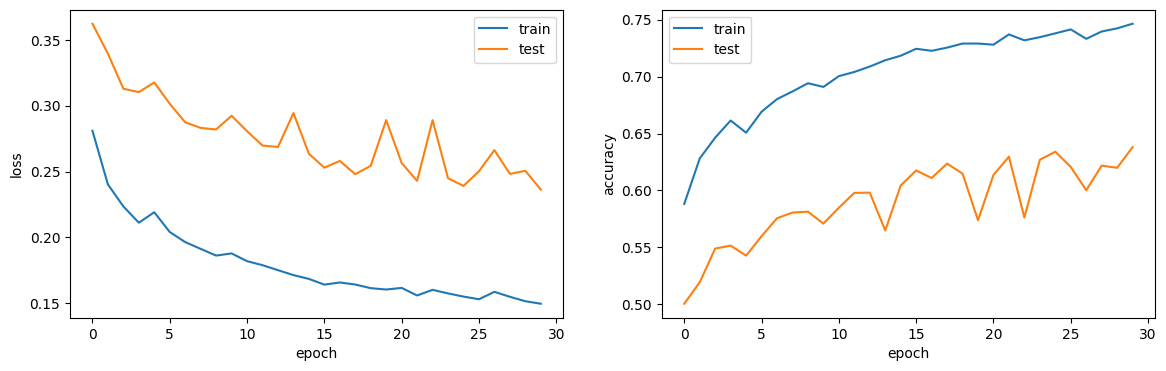

In [88]:
# Visualize
show_results(train_losses, test_losses, train_accuracies, test_accuracies)

In [91]:
model = UNet(in_channels=4, out_channels=1).to(device)
model.load_state_dict(torch.load(bestModel, map_location=device))
model.eval()

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(

In [108]:
predict_th = 0.5

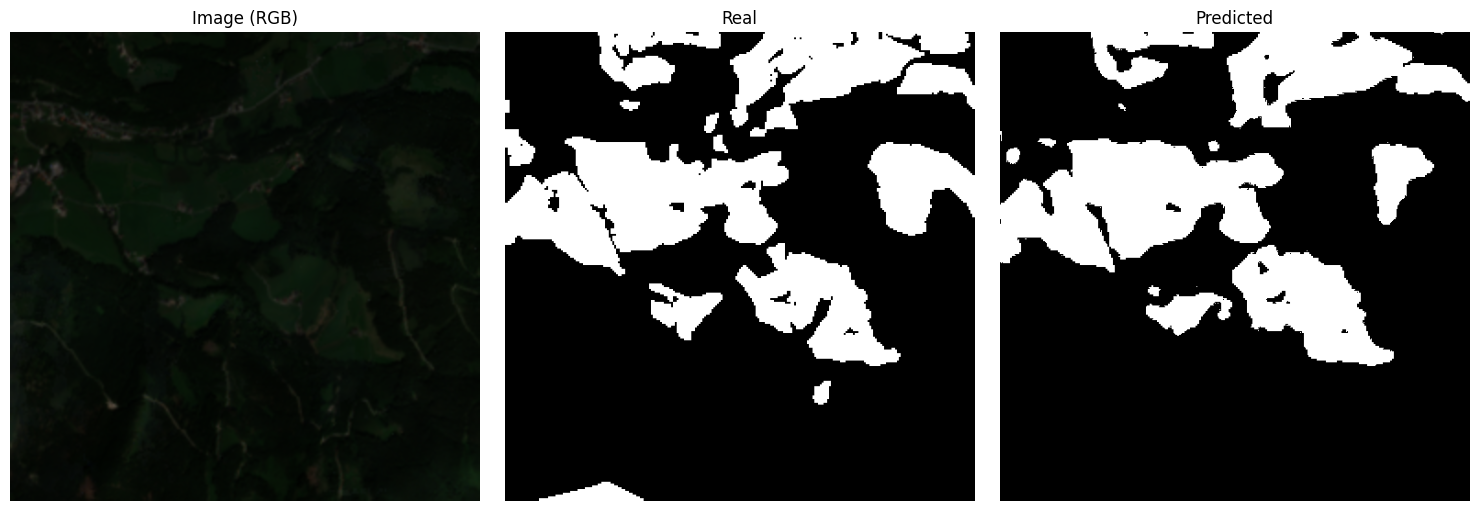

In [109]:
# Eval and visualize
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))
    imgs = imgs.to(device)
    outputs = model(imgs)
    pred_mask = (outputs[0] > predict_th).float().squeeze().cpu().numpy()
    img = imgs[0].cpu().numpy().transpose(1, 2, 0)
    mask = masks[0].cpu().numpy().squeeze()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img[:, :, :3])
axs[0].set_title('Image (RGB)')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Real')
axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title('Predicted')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#Empty cache and model
del model
gc.collect()
torch.cuda.empty_cache()

# Find metrics

In [166]:
weights_path

'/home/lcervantes/Dataset/Datasets/AI4boundariesDS/weightsTrainDS'

In [167]:
!ls /home/lcervantes/Dataset/Datasets/AI4boundariesDS/weightsTrainDS

weights_20250703_181936.pth  weights_20250703_194645.pth
weights_20250703_183939.pth  weights_20250703_203658.pth
weights_20250703_191058.pth


In [168]:
model_pth = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/weightsTrainDS/weights_20250703_203658.pth"

In [169]:
#Load model weights
model = UNet(in_channels=4, out_channels=1).to(device)
model.load_state_dict(torch.load(model_pth, map_location=device))
model.eval()

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.05, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout2d(p=0.05, inplace=False)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.05, inplace=False)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

In [41]:
device = torch.device("cpu")
torchsummary.summary(model.to("cpu"), input_size=(4, 512, 512), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           2,368
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
         Dropout2d-4         [-1, 64, 512, 512]               0
            Conv2d-5         [-1, 64, 512, 512]          36,928
       BatchNorm2d-6         [-1, 64, 512, 512]             128
              ReLU-7         [-1, 64, 512, 512]               0
         Dropout2d-8         [-1, 64, 512, 512]               0
        DoubleConv-9         [-1, 64, 512, 512]               0
        MaxPool2d-10         [-1, 64, 256, 256]               0
           Conv2d-11        [-1, 128, 256, 256]          73,856
      BatchNorm2d-12        [-1, 128, 256, 256]             256
             ReLU-13        [-1, 128, 256, 256]               0
        Dropout2d-14        [-1, 128, 2

In [44]:
print(torch.cuda.is_available())
device = torch.device(2 if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

True
Device: cuda:2


In [183]:
#Get all predictions of binary masks and save them in the predictions dir
currentPredictions = os.path.join(predictions_path, "preds_20250703_203658")
os.makedirs(currentPredictions, exist_ok=True)
img_idx = 0
with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.sigmoid(outputs)
        preds = (preds > predict_th).float()
        batch_size = preds.size(0)
        for i in range(batch_size):
            save_image(preds[i], os.path.join(currentPredictions, f"pred_{img_idx:03d}.png"))
            img_idx += 1

In [40]:
def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    jaccard = jaccard_score(target, pred, zero_division=0)
    precision = precision_score(target, pred, zero_division=0)
    recall = recall_score(target, pred, zero_division=0)
    dice = f1_score(target, pred, zero_division=0)

    return {
        "Jaccard": jaccard,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall
    }

In [41]:
def compute_metrics_batch(pred, target):
    # pred y target: (batch, 1, H, W) or (batch, H, W)
    batch_size = pred.shape[0]
    results = {"Jaccard": [], "Dice": [], "Precision": [], "Recall": []}
    for i in range(batch_size):
        p = pred[i].cpu().numpy().astype(np.uint8).flatten()
        t = target[i].cpu().numpy().astype(np.uint8).flatten()
        results["Jaccard"].append(jaccard_score(t, p, zero_division=0))
        results["Dice"].append(f1_score(t, p, zero_division=0))
        results["Precision"].append(precision_score(t, p, zero_division=0))
        results["Recall"].append(recall_score(t, p, zero_division=0))
    # Average batch metrics
    return {k: np.mean(v) for k, v in results.items()}

In [110]:
predict_th = 0.5

In [111]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in test_loader:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()
        metrics = compute_metrics_batch(pred, mask)
        metrics_list.append(metrics)

In [112]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.7177
Dice: 0.8165
Precision: 0.8069
Recall: 0.8516


In [113]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in val_loader:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [114]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.6390
Dice: 0.7646
Precision: 0.7168
Recall: 0.8435


In [48]:
model

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(